In [1]:
import pandas as pd
import numpy as np
import pm4py
import os
import networkx as nx
import matplotlib.pyplot as plt
from pm4py.discovery import discover_petri_net_inductive as pn_inductive

import custom_functions as cf

pd.set_option('display.max_columns', None)

In [2]:
def load_sample_data(path, nr_cases_subset=None):
    log = pm4py.read_xes(path)
    df = pd.DataFrame(log)
    
    if nr_cases_subset:
        # Sort the DataFrame by case ID and timestamp
        df_sorted = df.sort_values(['case:concept:name', 'time:timestamp'])
        
        # Get the first x unique case IDs
        first_x_cases = df_sorted['case:concept:name'].unique()[:nr_cases_subset]
        
        # Filter the DataFrame to keep only these cases
        df = df_sorted[df_sorted['case:concept:name'].isin(first_x_cases)]
        
    return log, df   

In [3]:
def create_petri_net_and_process_tree(log):

    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

    petri_net, im, fm = pn_inductive(log, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
    
    process_tree = pm4py.objects.conversion.wf_net.converter.apply(petri_net, im, fm)
    
    return petri_net, im, fm, process_tree

In [4]:

def find_causal_relationships(net):
    def find_successors_of_transition(transition):
        sources = {transition}
        targets, visited = set(), set()
        while sources:
            source = sources.pop()
            if not (type(source) is pm4py.PetriNet.Transition and source.label is not None):
                visited.add(source)
            for arc in source.out_arcs:
                if arc.target in visited:
                    continue
                if type(arc.target) is pm4py.PetriNet.Transition and arc.target.label is not None:
                    targets.add(arc.target)
                else:
                    sources.add(arc.target)
        return targets
    
    def find_successors(net):
        return {transition: find_successors_of_transition(transition) for transition in net.transitions if
                transition.label is not None}
    
    dict_succ = find_successors(net)
    result = []
    for key, item in dict_succ.items():
        for s in item:
            result.append((key.label, s.label))
    return result

In [5]:
def create_hand_over_of_work_social_network(df, causal_events, min_weight, show_labels=False):
    """
    Creates a directed social network graph where nodes are people (org:resource), and edges represent transitions 
    of work between people for each causal event. Self-loops (transitions to oneself) are ignored.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the event log, which must include the following columns:
        - 'case:concept:name' for case ID
        - 'org:resource' for the resource (person) handling the event
        - 'time:timestamp' for the event's timestamp
    
    Returns:
    G (networkx.DiGraph): A directed graph representing the social network of people based on transitions between them.
    """
    
    # Ensure timestamp column is datetime
    df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])
    
    # Sort the dataframe by case ID and timestamp
    df_sorted = df.sort_values(by=['case:concept:name', 'time:timestamp'])

    # Initialize a directed graph
    G = nx.DiGraph()

    # Map events to their respective users and timestamps within each case
    event_to_user = df_sorted.groupby(['case:concept:name', 'concept:name']).agg({
        'org:resource': 'last',  # get the last user that handled the event in a case
        'time:timestamp': 'last'  # the last time the event was handled
    }).reset_index()

    # Create edges based on causal_events
    for (event_a, event_b) in causal_events:
        # Find events that match event_a and event_b in the same case
        events_a = event_to_user[event_to_user['concept:name'] == event_a]
        events_b = event_to_user[event_to_user['concept:name'] == event_b]
        
        events_b_dict = dict(zip(events_b['case:concept:name'], events_b['org:resource']))
        
        # Iterate over all cases to find matching pairs
        for _, event_a_row in events_a.iterrows():
            if event_a_row['case:concept:name'] in events_b_dict:
                if event_a_row['org:resource'] != events_b_dict[event_a_row['case:concept:name']]:
                    resource_a = event_a_row['org:resource']
                    resource_b = events_b_dict[event_a_row['case:concept:name']]
                    if G.has_edge(resource_a, resource_b):
                            G[resource_a][resource_b]['weight'] += 1
                    else:
                        G.add_edge(resource_a, resource_b, weight=1)

    # Remove edges below threshold
    edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if data['weight'] < min_weight]
    G.remove_edges_from(edges_to_remove)

    # Plot the network graph
    plt.figure(figsize=(14, 14), facecolor='white')  # Ensure white background
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Positions for all nodes

    # Extract edge weights for visualization
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Normalize weights for better visualization
    max_weight = max(weights) if weights else 1
    normalized_weights = [5 * (w / max_weight) for w in weights]  # Scale weights to [0,5]

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color='lightblue', edgecolors='black')

    # Draw edges with arrows
    nx.draw_networkx_edges(
        G, pos, 
        edgelist=G.edges(), 
        arrowstyle='->', 
        arrowsize=20, 
        edge_color='gray', 
        width=normalized_weights,
        connectionstyle='arc3,rad=0.1'  # Slight curvature for better visibility
    )

    if show_labels:
        # Draw labels
        nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
    
    # Add title
    plt.title("Directed Social Network of People Based on Causal Event Transitions", fontsize=16, color='black')

    # Remove axis
    plt.axis('off')
    
    # Improve layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

    return G


In [11]:
def plot_clusters(G, Handover_of_work_matrix_clusters):
    # Turnn matrix into resource:cluster dictionary
    clusters = dict(Handover_of_work_matrix_clusters['cluster'])
    clusters = {key: int(value) for key, value in clusters.items()}

    # Create a color map for each unique group
    unique_groups = set(clusters.values())
    colors = plt.get_cmap('tab20', len(unique_groups))  # Use a colormap with enough colors
    group_color_map = {group: colors(i) for i, group in enumerate(unique_groups)}

    # Assign colors to nodes based on their group
    node_colors = [group_color_map[clusters.get(node, 'default')] for node in G.nodes]

    # Plot the network graph
    plt.figure(figsize=(14, 14), facecolor='white')  # Ensure white background
    pos = nx.spring_layout(G, seed=42, k=0.5)  # Positions for all nodes

    # Extract edge weights for visualization
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    # Normalize weights for better visualization
    max_weight = max(weights) if weights else 1
    normalized_weights = [5 * (w / max_weight) for w in weights]  # Scale weights to [0,5]

    # Draw nodes with group-specific colors
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color=node_colors, edgecolors='black')

    # Draw edges with arrows
    nx.draw_networkx_edges(
        G, pos, 
        edgelist=G.edges(), 
        arrowstyle='->', 
        arrowsize=20, 
        edge_color='gray', 
        width=normalized_weights,
        connectionstyle='arc3,rad=0.1'  # Slight curvature for better visibility
    )

    # Add title
    plt.title("Directed Social Network of People Based on Causal Event Transitions", fontsize=16, color='black')

    # Remove axis
    plt.axis('off')

    # Improve layout
    plt.tight_layout()

    # Display the plot
    plt.show()

C:\Users\marij\Documents\Universiteit_local\Master_Year2\Process_Mining\test-cde\pythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 4/4 [00:00<00:00, 1334.49it/s]


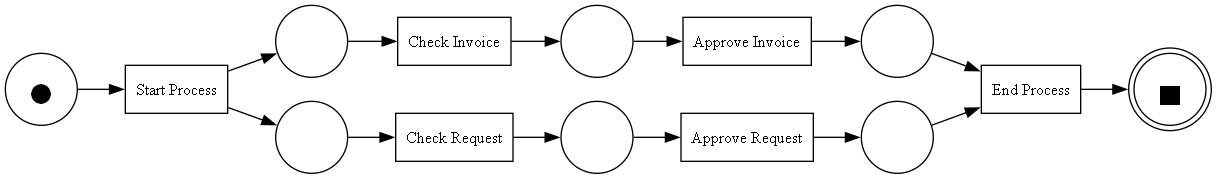

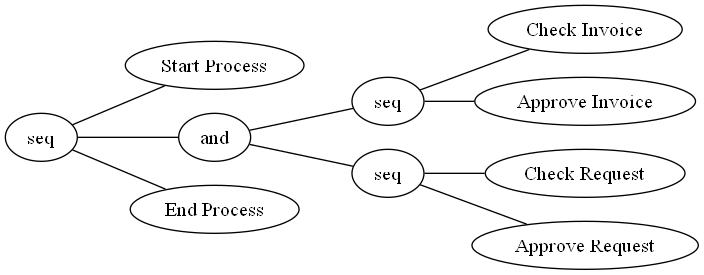

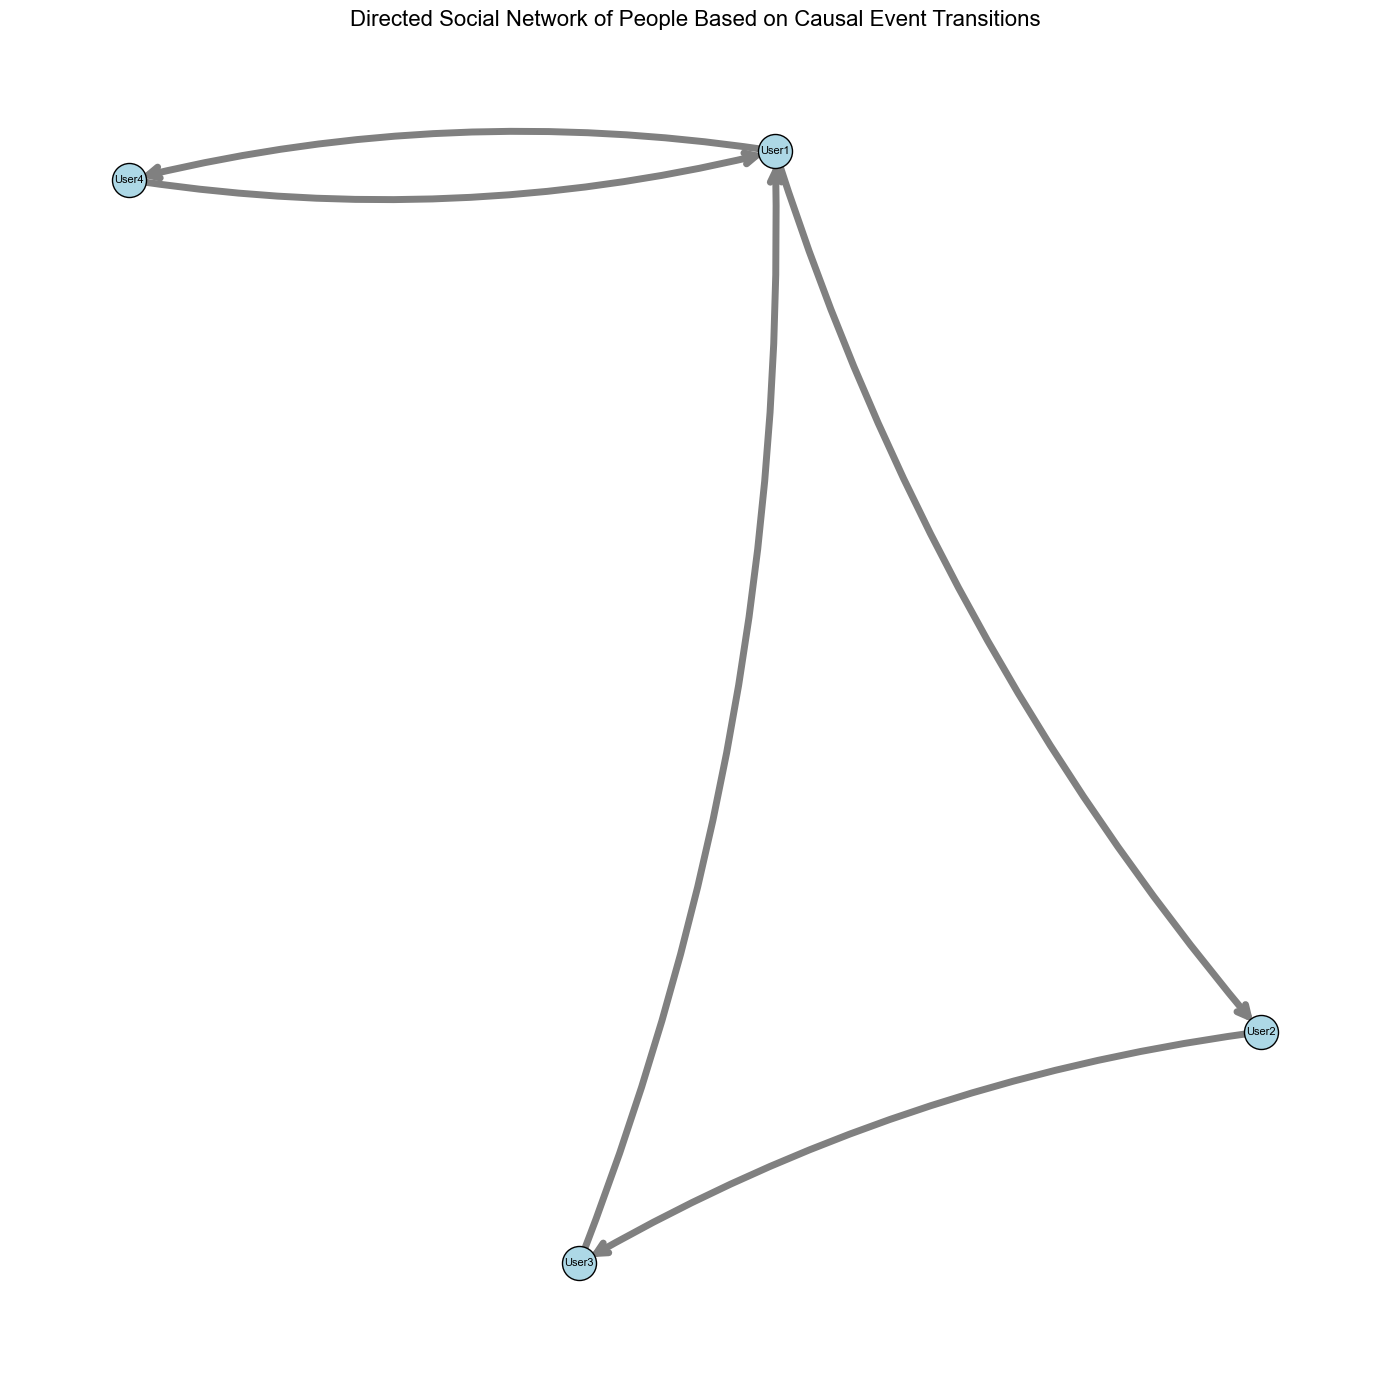

In [7]:

log, df = load_sample_data('synthetic_event_log.xes', nr_cases_subset=None)
petri_net, im, fm, process_tree = create_petri_net_and_process_tree(log)
pm4py.vis.view_petri_net(petri_net, im, fm)
pm4py.vis.view_process_tree(process_tree)

causal_events = find_causal_relationships(petri_net)

G = create_hand_over_of_work_social_network(df, causal_events, min_weight=0, show_labels=True)


parsing log, completed traces :: 100%|██████████| 3093/3093 [00:13<00:00, 222.70it/s]


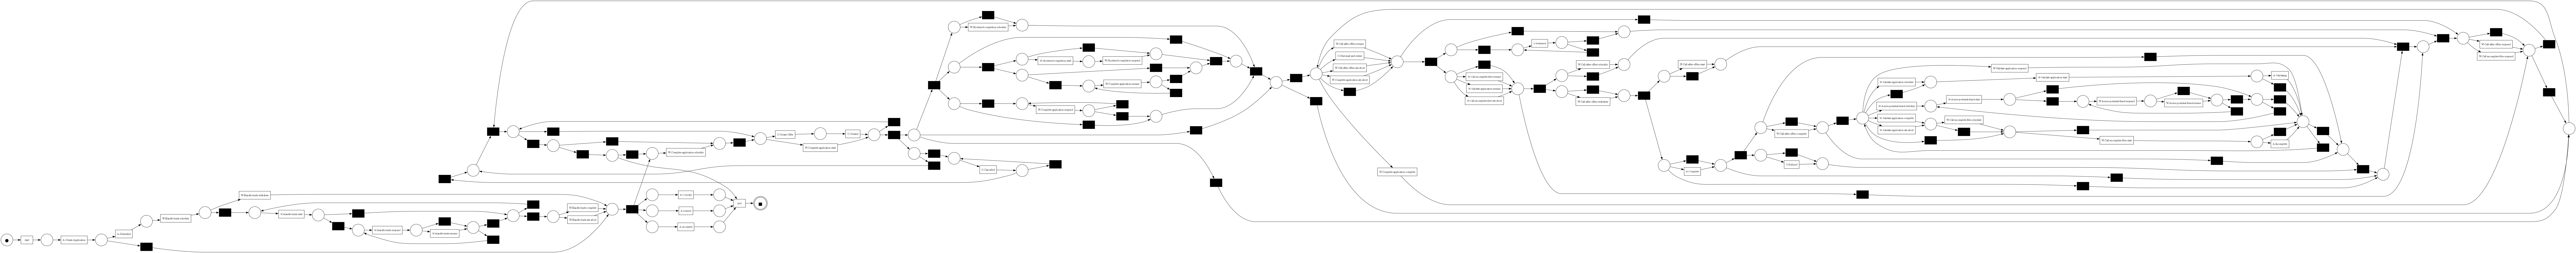

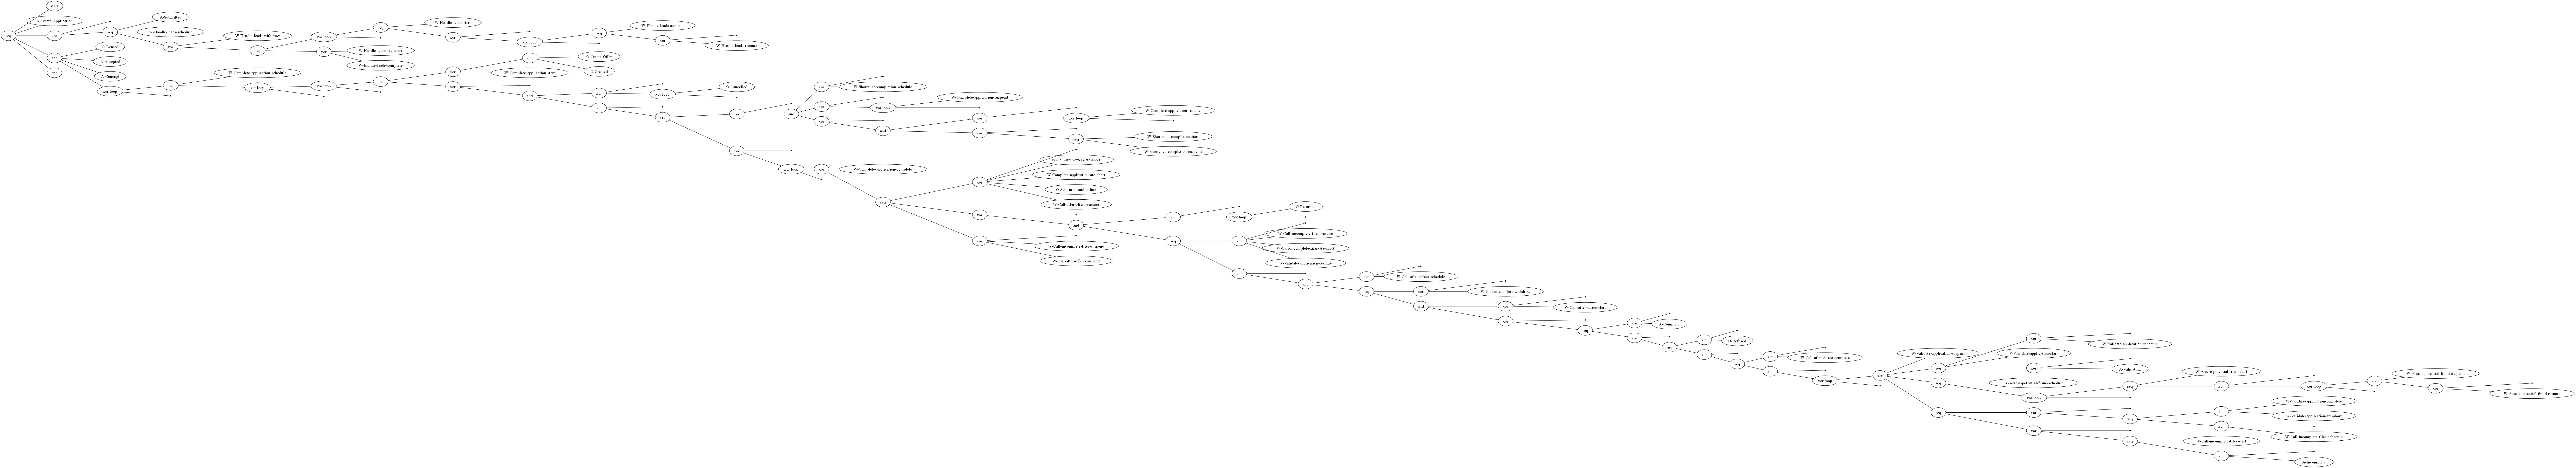

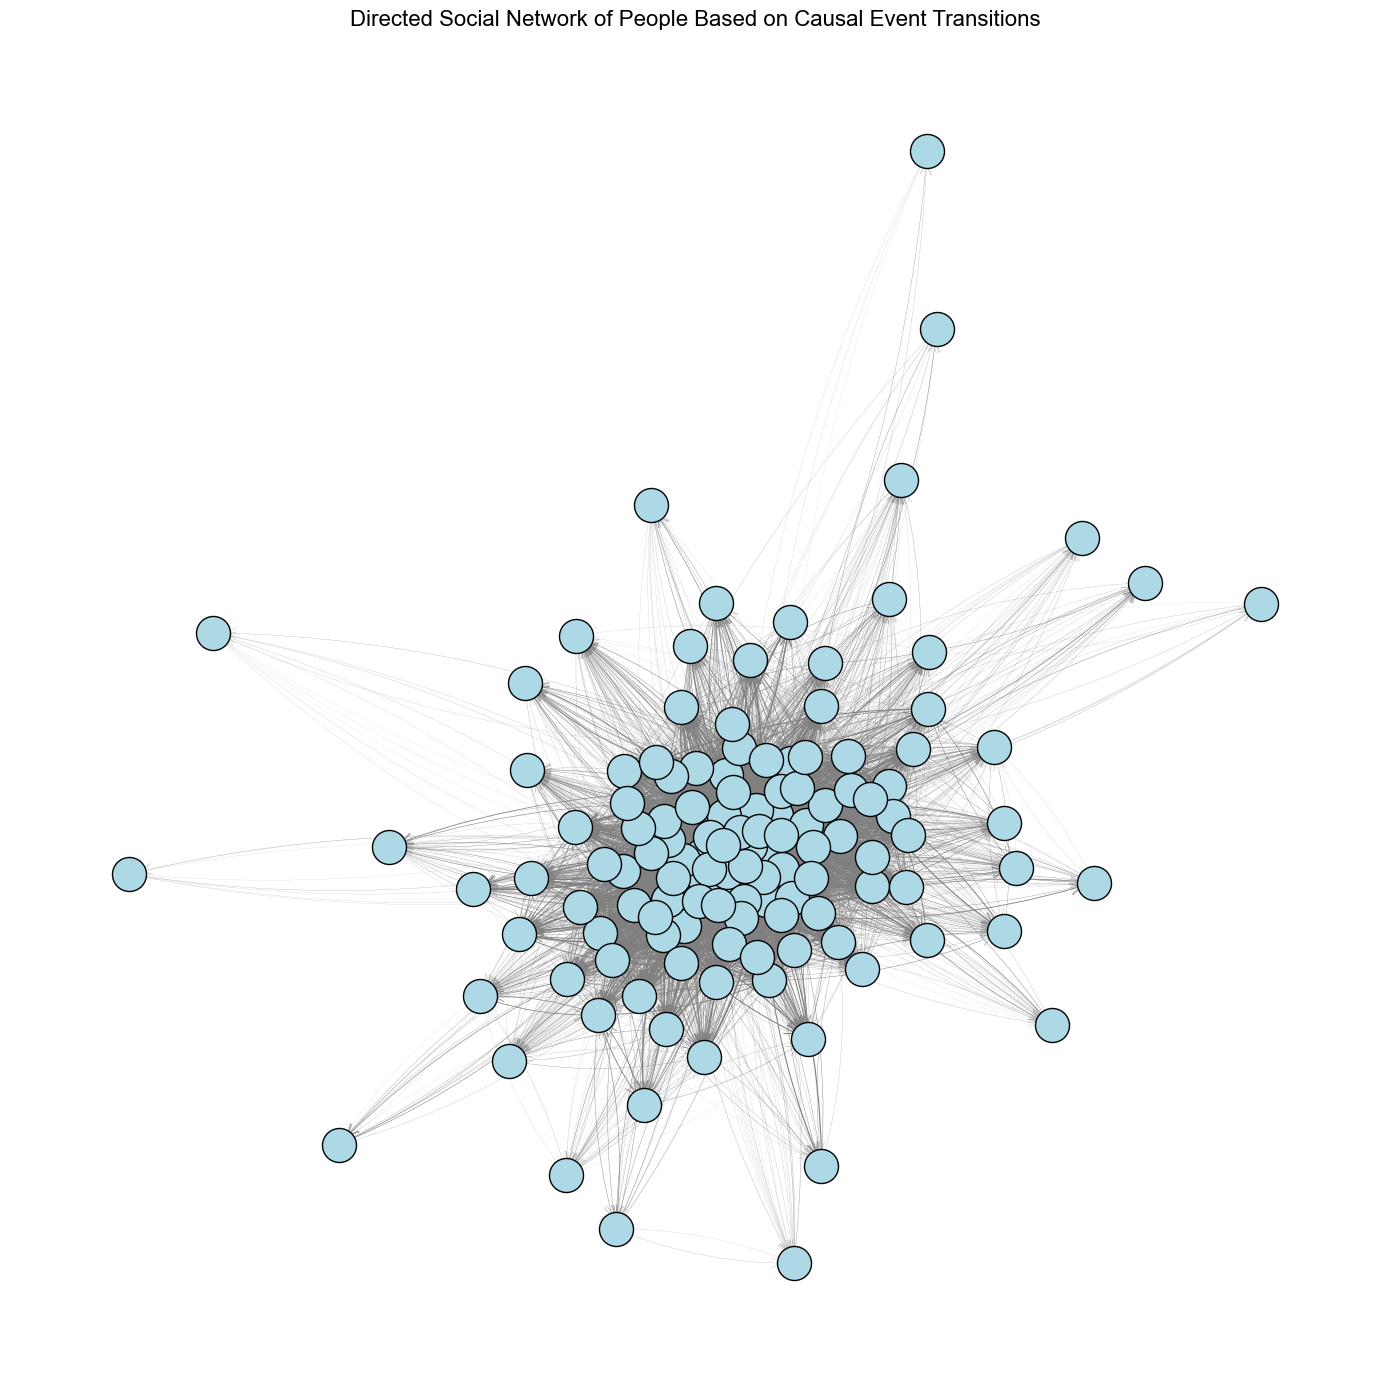

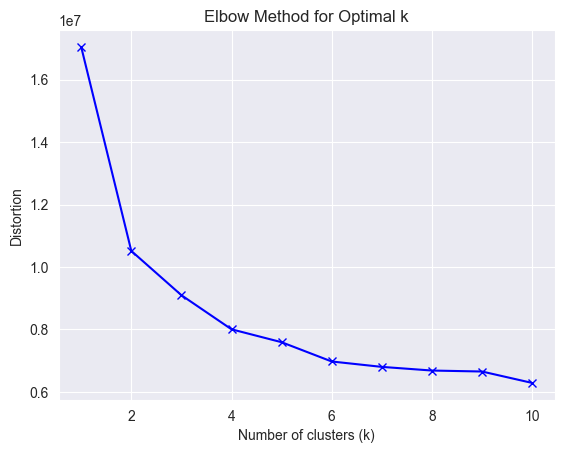


Clusters added to resource_activity_matrix.


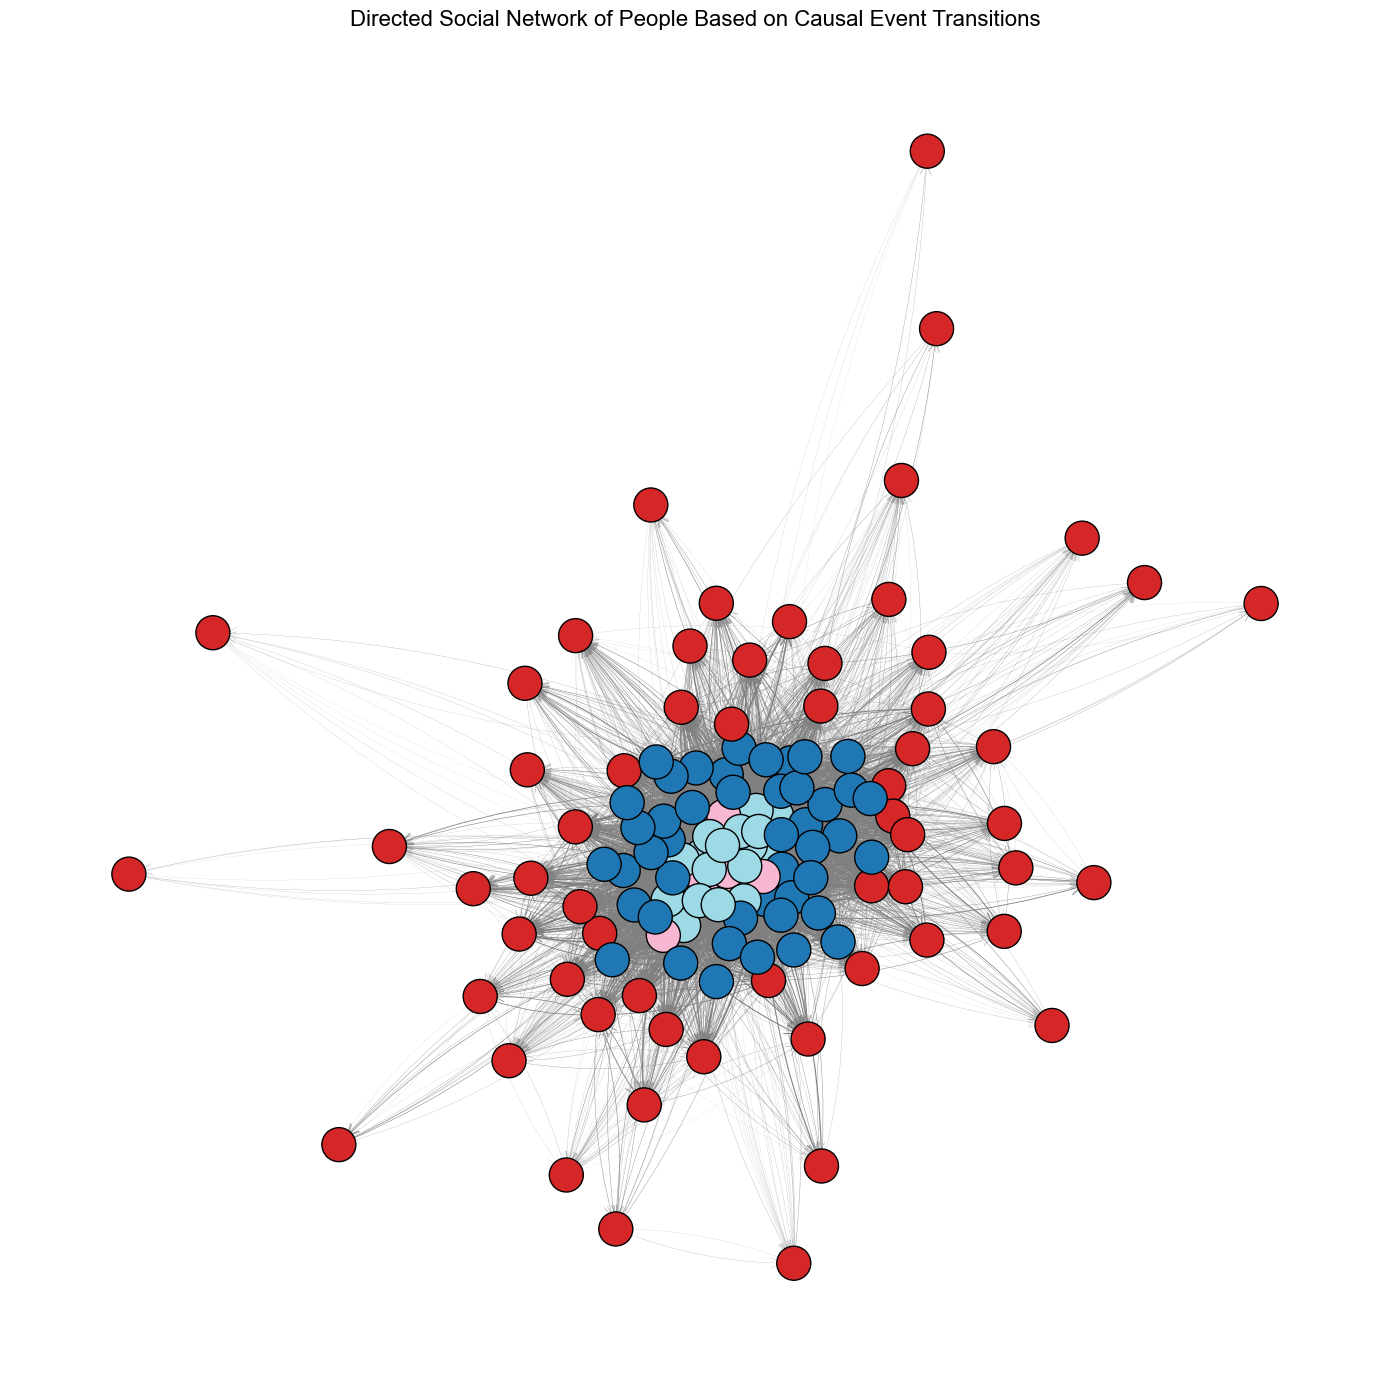

In [12]:
log, df = load_sample_data('BPI2017Denied(3).xes', nr_cases_subset=1000)
petri_net, im, fm, process_tree = create_petri_net_and_process_tree(log)
pm4py.vis.view_petri_net(petri_net, im, fm)
pm4py.vis.view_process_tree(process_tree)

causal_events = find_causal_relationships(petri_net)

G = create_hand_over_of_work_social_network(df, causal_events, min_weight=5, show_labels=False)

adjacency_matrix_df = nx.to_pandas_adjacency(G, weight='weight')

resource_profiles, resources = cf.get_resource_profiles(adjacency_matrix_df)
cf.elbow_method(resource_profiles)

Handover_of_work_matrix_clusters = cf.ask_for_k_or_clustering(adjacency_matrix_df, resource_profiles, resources)

plot_clusters(G, Handover_of_work_matrix_clusters)
